### Import Required Libraries

In [1]:
# import some require library
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import transforms
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import os
os.environ['SSL_CERT_FILE'] = '/etc/ssl/certs/ca-certificates.crt'

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


### Customize Image Dataset

In [2]:
class CustomImageDataset(Dataset):
    
    def __init__(self, root_dir, transform=None, include_feature_vector=True):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_list = self._generate_image_list()
        self.include_feature_vector = include_feature_vector

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        label, img_path = self.image_list[idx]

        # Use PIL to open the image
        image = Image.open(img_path).convert('RGB')

        image_name = os.path.basename(os.path.dirname(img_path))  # Get subcategory name
        # label = class_name  # The category name is the label

        if self.transform:
            image = self.transform(image)

        feature_vector = np.array([[1, 1, 1]])
        if self.include_feature_vector:
            # Load the pre-computed vector from the corresponding .npy file
            vector_name = f'{os.path.splitext(os.path.basename(img_path))[0]}_vector.npy'
            vector_path = os.path.join(os.path.dirname(img_path), vector_name)
            feature_vector = np.load(vector_path)

        return label, image, image_name, feature_vector

    def _generate_image_list(self):
        image_list = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for root, _, files in os.walk(class_path):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        image_list.append((class_name, os.path.join(root, file)))
        return image_list
    
    def process_images_and_save_vectors(self, get_vector_func):
        for idx in range(len(self)):
            label, _, _, _ = self.__getitem__(idx)  # Use __getitem__ method to get label and image path
            img_path = self.image_list[idx][1]  # Extract image path from image_list
            print(img_path)
            image_feature = get_vector_func(img_path)
            # Save the image feature vector in the same directory with .npy extension
            save_path = os.path.splitext(img_path)[0] + '_vector.npy'
            np.save(save_path, image_feature)

### Basic Image Preprocessing

In [3]:
# Define additional transformations
horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)
random_rotation = transforms.RandomRotation(degrees=10)
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
# grayscale = transforms.Grayscale(num_output_channels=3)  # Keep 3 channels for RGB images

# Compose transformations including additional ones
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.CenterCrop(224),
    horizontal_flip,
    # random_rotation,
    # color_jitter,
    # grayscale,  # You can include or exclude this based on your requirements
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Dataset & DataLoader

In [4]:
# Define the dataset
image_directory = 'Fashion_Products_Dataset/'  # Replace with the actual directory path
custom_dataset = CustomImageDataset(root_dir=image_directory, transform=image_transform, include_feature_vector=False)

# Define the DataLoader
batch_size = 32
data_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True)

### Data Exploration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


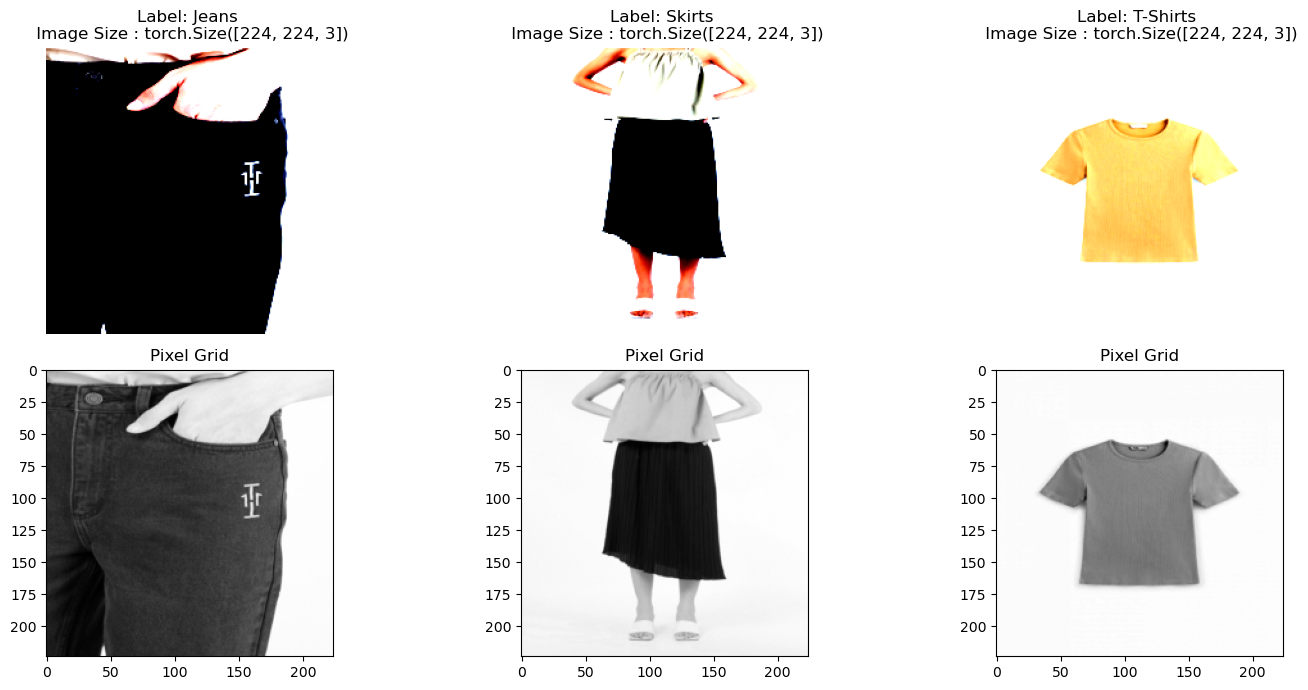

In [5]:
# Now let's plot some random images
def show_images_with_grid(images, labels, num_images=3):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 7))

    for i in range(num_images):
        image = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for displaying with matplotlib
        label = labels[i]

        axes[0, i].imshow(image)
        axes[0, i].set_title(f"Label: {label} \n Image Size : {image.size()}")
        axes[0, i].axis('off')

        # Display pixel grid
        axes[1, i].imshow(images[i][0], cmap='gray')  # Assuming images are in grayscale
        axes[1, i].set_title("Pixel Grid")
        axes[1, i].axis('on')

    plt.tight_layout()
    plt.show()

# Get a batch from the DataLoader
for labels, images,_,_ in data_loader:
    # Show the first 5 images along with their labels and pixel grids
    show_images_with_grid(images, labels, num_images=3)
    break  # Break after showing the first batch


### Load Pretrained Model

In [6]:
# Load the pretrained model
model = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
model.eval()

# Image transforms
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

D:\Mamba\mambaforge\envs\capstone2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Mamba\mambaforge\envs\capstone2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Define a function for image embedding and feature extraction

In [7]:
# Define function to convert image to vector
def get_vector(image_name):
    # 1. Load the image with Pillow library
    img = Image.open(image_name)
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
      my_embedding.copy_(o.data.reshape(o.data.size(1)))
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)

    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding.numpy()

### Now Let's convert each images to vector representation

In [8]:
# Call function process_images_and_save_vectors
custom_dataset.process_images_and_save_vectors(get_vector)
print('\nDone')

Fashion_Products_Dataset/Dress\A Line V-Neck Dress\Midi-Dress (1).jpg
Fashion_Products_Dataset/Dress\A Line V-Neck Dress\Midi-Dress (2).jpg
Fashion_Products_Dataset/Dress\A Line V-Neck Dress\Midi-Dress (3).jpg
Fashion_Products_Dataset/Dress\A Line V-Neck Dress\Midi-Dress (4).jpg
Fashion_Products_Dataset/Dress\A Line V-Neck Dress\Midi-Dress (5).jpg
Fashion_Products_Dataset/Dress\A Line V-Neck Dress\Midi-Dress (6).jpg
Fashion_Products_Dataset/Dress\Aline Dress\ALINE-DRESS (1).jpg
Fashion_Products_Dataset/Dress\Aline Dress\ALINE-DRESS (10).jpg
Fashion_Products_Dataset/Dress\Aline Dress\ALINE-DRESS (2).jpg
Fashion_Products_Dataset/Dress\Aline Dress\ALINE-DRESS (4).jpg
Fashion_Products_Dataset/Dress\Aline Dress\ALINE-DRESS (5).jpg
Fashion_Products_Dataset/Dress\Aline Dress\ALINE-DRESS (6).jpg
Fashion_Products_Dataset/Dress\Aline Dress\ALINE-DRESS (7).jpg
Fashion_Products_Dataset/Dress\Aline Dress\ALINE-DRESS (8).jpg
Fashion_Products_Dataset/Dress\Aline Dress\ALINE-DRESS (9).jpg
Fashion_Prod

### Dataset & DataLoader included Feature Vector

In [9]:
# Define the dataset
image_directory = 'Fashion_Products_Dataset/'  # Replace with the actual directory path
custom_dataset = CustomImageDataset(root_dir=image_directory, transform=image_transform, include_feature_vector=True)

# Define the DataLoader
batch_size = 64
data_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True)

In [10]:
dataset_size = len(custom_dataset)
print(f'Total number of images in the dataset: {dataset_size}')

Total number of images in the dataset: 7248


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


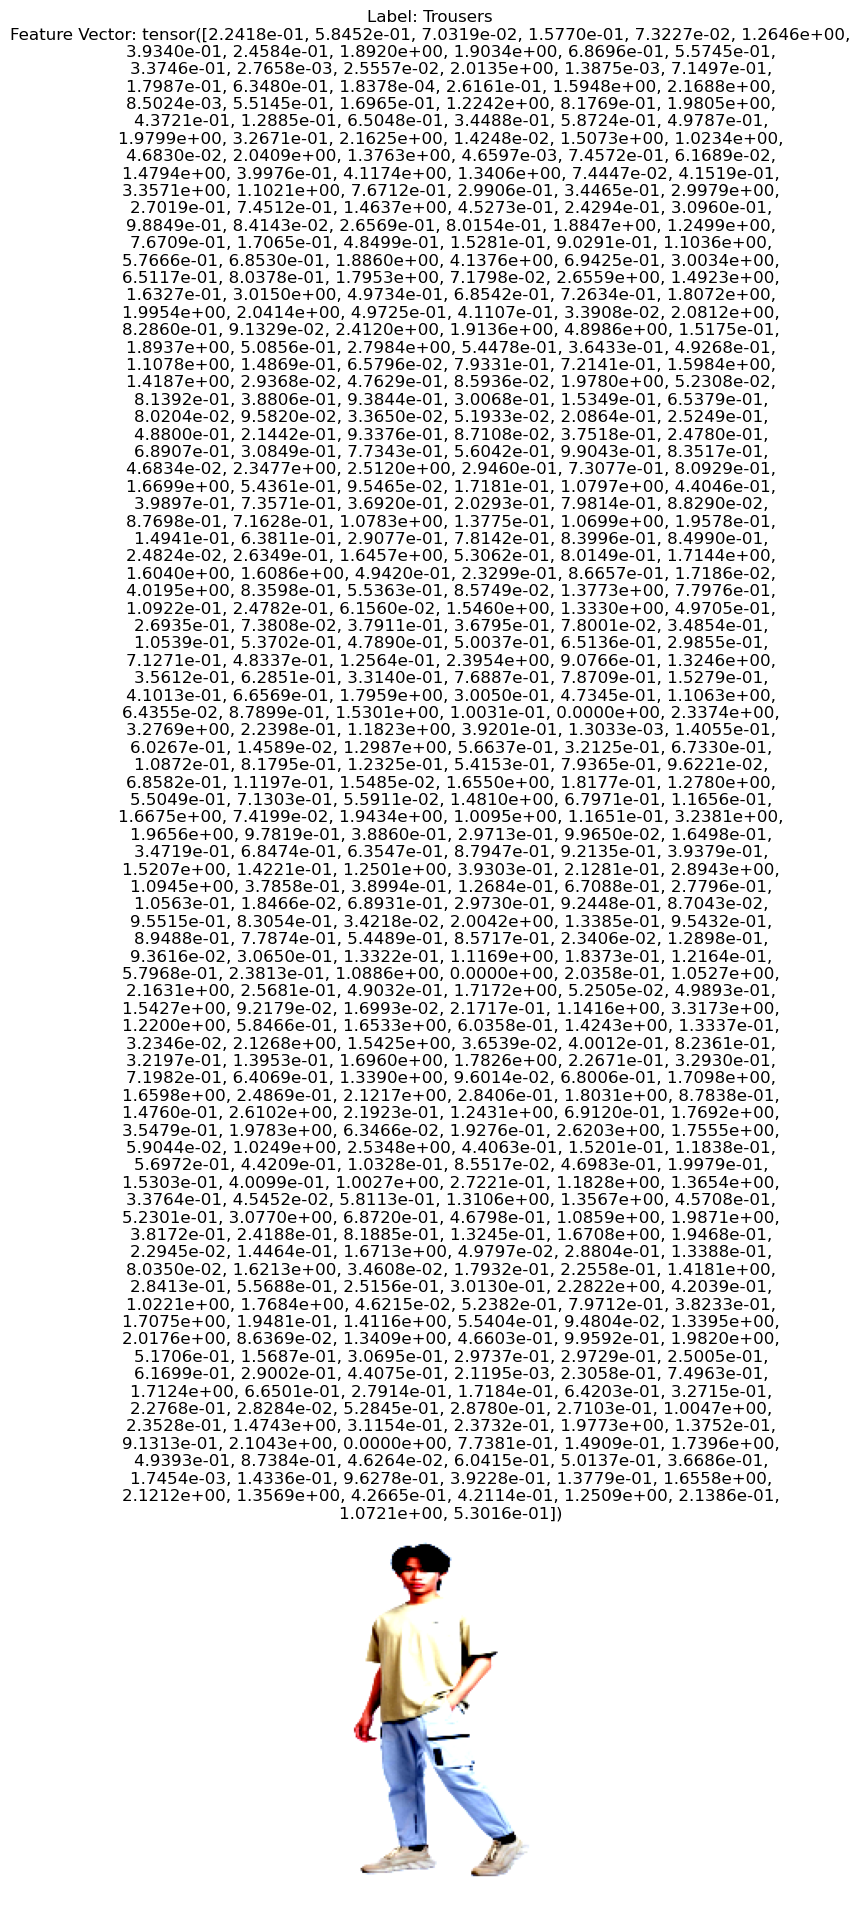

In [11]:
# Let's display a single image with label and feature vector
def show_image_with_info(image, label, feature_vector):
    plt.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for displaying with matplotlib
    plt.title(f"Label: {label}\nFeature Vector: {feature_vector}")
    plt.axis('off')
    plt.show()

# Get a batch from the DataLoader (assuming batch size is 1)
for labels, images, _, feature_vectors in data_loader:
    # Show the first image along with its label and feature vector
    show_image_with_info(images[0], labels[0], feature_vectors[0])
    break  # Break after showing the first batch

In [12]:
flattened_embedding= feature_vectors[0].flatten().reshape(1, -1)
flattened_embedding = flattened_embedding.reshape(-1, 1)
if flattened_embedding.ndim == 2:
    print("Array is 2D")
else:
    print("Array is not 2D")

Array is 2D


### PCA

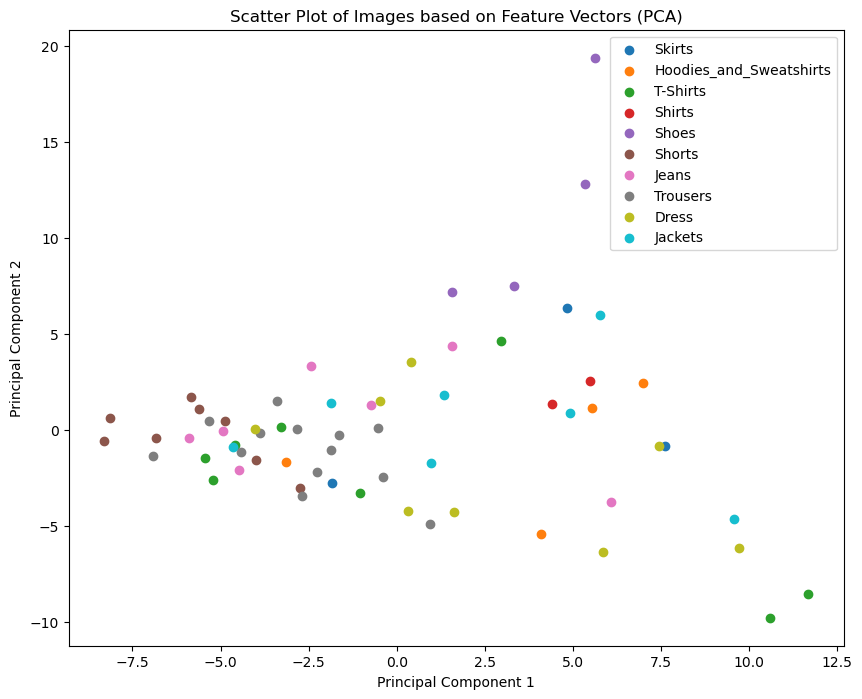

In [13]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_scatter(feature_vectors, labels):
    pca = PCA(n_components=10)
    reduced_features = pca.fit_transform(feature_vectors)

    plt.figure(figsize=(10, 8))
    for label in set(labels):
        indices = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], label=label)

    plt.title('Scatter Plot of Images based on Feature Vectors (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

plot_scatter(feature_vectors.numpy(), labels)


### Apply KNN for computing image similarity 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


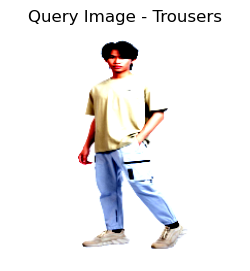

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


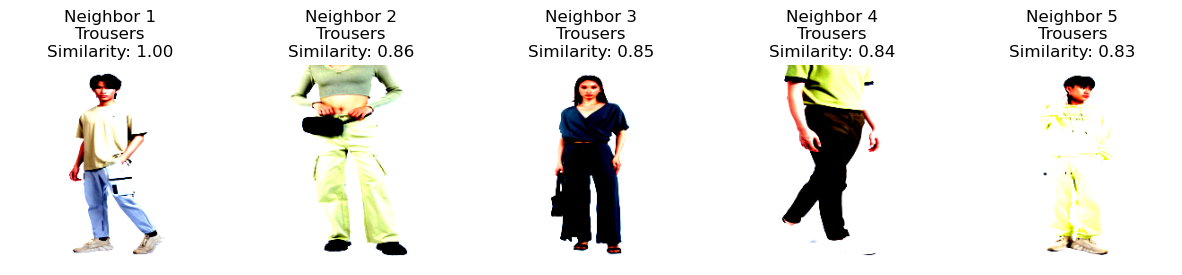

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
def find_k_nearest_neighbors(query_index, feature_vectors, images, labels, K=5):
    # Extract the feature vector of the query image
    query_vector = feature_vectors[query_index].reshape(1, -1)

    # Calculate cosine similarity
    similarities = cosine_similarity(query_vector, feature_vectors)

    # Find the K-nearest neighbors for the query image
    indices = similarities.argsort()[0][-K:][::-1]
    distances = similarities[0, indices]

    # Plot the query image
    plt.figure(figsize=(3, 3))
    plt.imshow(images[query_index].permute(1, 2, 0))  # Assuming images is a tensor with shape [20, 3, 224, 224]
    plt.title(f"Query Image - {labels[query_index]}")
    plt.axis('off')
    plt.show()

    # Plot the K-nearest neighbors
    plt.figure(figsize=(15, 5))
    for i in range(K):
        plt.subplot(1, K, i + 1)
        plt.imshow(images[indices[i]].permute(1, 2, 0))
        plt.title(f"Neighbor {i + 1}\n{labels[indices[i]]}\nSimilarity: {distances[i]:.2f}")
        plt.axis('off')
    plt.show()

query_index = 0

find_k_nearest_neighbors(query_index, feature_vectors, images, labels, K=5)